In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sl

In [123]:
# Setup Parameters
x_min = 0.
x_max = 100.
n_x = 1000
dt = 0.1

x_0 = x_min + (x_max - x_min) / 2
p_0 = 1.
sig = 0.01 * (x_max - x_min)

X = x_mesh = np.linspace(x_min, x_max, n_x)
dx = x_mesh[1] - x_mesh[0]
pi = np.pi

In [206]:
# Useful Functions
def normalization(wf: np.ndarray) -> np.ndarray:
    return wf / np.linalg.norm(wf)

def get_prob(wf: np.ndarray) -> np.ndarray:
    return np.abs(wf) ** 2

def overlap(f1: np.ndarray, f2: np.ndarray) -> float:
    return np.abs(np.dot(np.conj(f1), f2)) ** 2

class CrankNicolson:
    def __init__(self, dt=dt):
        dim = self.dim = len(X)
        diag = -2 * np.ones(dim)
        # diag[0] = diag[-1] = 1
        fac = - 0.5 * dt / dx ** 2
        upper = np.ones(dim)
        # upper[0] = upper[1] = 0
        lower = np.ones(dim)
        # lower[-1] = lower[-2] = 0
        self.Hdt = sp.dia_matrix(([diag, upper, lower], [0, 1, -1]), shape=(dim, dim), dtype=np.complex128) * fac
    
    def next(self, psi: np.ndarray) -> np.ndarray:
        dim = self.dim
        Hdt = self.Hdt
        b = (sp.eye(dim) - 1.j * Hdt / 2).dot(psi)
        A = (sp.eye(dim) + 1.j * Hdt / 2).tocsc()
        return sl.spsolve(A, b)
        # return normalization((sp.eye(dim) + 1j * Hdt).dot(psi))
    
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.next(x)
    
class FFTSolv:
    # The choice of kmesh is matter!, large k is not exact!.
    def __init__(self, inter: int=1, cutoff: int=1, dt=dt):
        self.dx = dx
        self.dk = 2 * pi / ((x_max - x_min) * inter)
        self.p = inter
        self.kmesh = kmesh_ele = np.arange(len(X) * inter)
       
        for i in range(1, cutoff):
            self.kmesh = np.append(self.kmesh, kmesh_ele * i)
        self.kmesh = np.append(-self.kmesh[-1:0:-1], self.kmesh)
        self.kmesh = self.kmesh * self.dk
        self.indl = {(s, l): np.arange(l * len(X) + s, l * len(X) + len(X) * inter, inter) for l in range(-cutoff, cutoff) for s in range(inter)}
        
        self.dyna_phase = np.exp(-1.j * self.kmesh ** 2 * dt / 2)
    
    def cft(self, x: np.ndarray) -> np.ndarray:
        x_re = np.real(x)
        x_im = np.imag(x)
        res = np.zeros(len(self.kmesh), dtype=np.complex128)
        cache_fft = {}
        for s, l in self.indl:
            indl = self.indl[(s, l)]
            if s not in cache_fft:
                cache_fft[s] = np.fft.fft(np.exp(-1.j * 2 * pi * s * np.arange(len(X)) / (len(X) * self.p)) * x)
            res[indl] = cache_fft[s]
        res = np.exp(-1.j * self.kmesh * x_min) * res
        return res
    
    def cft_inv(self, x: np.ndarray) -> np.ndarray:
        x = np.exp(1.j * self.kmesh * x_min) * x
        cache_fft = {}
        res = np.zeros(len(X), dtype=np.complex128)
        for s, l in self.indl:
            indl = self.indl[(s, l)]
            if s not in cache_fft:
                cache_fft[s] = np.exp(1.j * 2 * pi * s * np.arange(len(X)) / (len(X) * self.p))
            res += cache_fft[s] * np.fft.ifft(x[indl])
        
        return res

    def next(self, psi: np.ndarray) -> np.ndarray:
        fac = self.dx * self.dk / (2 * pi)
        x = self.cft_inv(self.dyna_phase * self.cft(psi))
        return normalization(x)
    
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.next(x)
    
class FFTSolvRough:
    def __init__(self, dt=dt):
        # self.dx = dx
        self.kmesh = np.fft.fftfreq(len(X)) / dx * 2 * pi
        self.dyna_phase = np.exp(-1.j * self.kmesh ** 2 * dt/2)
        
    def next(self, psi:np.ndarray) -> np.ndarray:
        psi_moment = np.fft.fft(psi)
        return normalization(np.fft.ifft(psi_moment * self.dyna_phase))
    
    def __call__(self, x:np.ndarray) -> np.ndarray:
        return self.next(x)

Crank_Nicolson: 0.9999999999999996	FFT: 0.9999999999999996	Overlap: 0.9999999999999998
Crank_Nicolson: 0.9999999999999912	FFT: 0.9999999999999998	Overlap: 0.9741439739121245
Crank_Nicolson: 0.9999999999999845	FFT: 1.0000000000000004	Overlap: 0.9006282326746319
Crank_Nicolson: 0.9999999999999772	FFT: 1.0000000000000002	Overlap: 0.7905423253645585
Crank_Nicolson: 0.9999999999999685	FFT: 1.0000000000000002	Overlap: 0.6592069343058492
Crank_Nicolson: 0.9999999999999607	FFT: 0.9999999999999998	Overlap: 0.5226279758251154
Crank_Nicolson: 0.9999999999999535	FFT: 0.9999999999999999	Overlap: 0.3943536546534849
Crank_Nicolson: 0.9999999999999458	FFT: 1.0000000000000007	Overlap: 0.28355198452876174
Crank_Nicolson: 0.9999999999999384	FFT: 1.0000000000000004	Overlap: 0.19455338774916522
Crank_Nicolson: 0.9999999999999304	FFT: 0.9999999999999998	Overlap: 0.12757769217170528


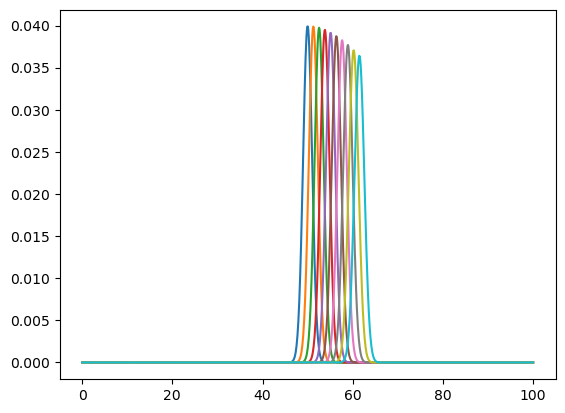

In [210]:
# Initialization

p_0 = 50

ini_psi = normalization(np.exp( - (X - x_0) ** 2 / (4 * sig ** 2) - 1.j * (X - x_0) * p_0))
ini_psi_op = normalization(np.exp( - (X - x_0) ** 2 / (4 * sig ** 2) + 1.j * (X - x_0) * p_0))

# Dynamics

import matplotlib.pyplot as plt


cn_nn = 100
ft_nn = 1
cn_solver = CrankNicolson(dt / cn_nn)
# ft_solver = FFTSolv(inter=1, cutoff=1, dt=dt / ft_nn)
ft_solver = FFTSolvRough(dt / ft_nn)
psi1 = ini_psi
psi2 = ini_psi
for i in range(10):
    p1 = get_prob(psi1)
    p2 = get_prob(psi2)
    plt.plot(X, p2)

    print(f"Crank_Nicolson: {sum(p1)}\tFFT: {sum(p2)}\tOverlap: {overlap(psi1, psi2)}")
    # print(f"<X>: {sum(p1 * X), sum(p2 * X)}\t<v>: {sum((p1-p2) * X) / (i+1)}")
    
    for _ in range(cn_nn):
        psi1 = cn_solver(psi1)
        
    for _ in range(ft_nn):
        psi2 = ft_solver(psi2)
    
    
    psi1[0] = psi1[-1] = 0
    psi2[0] = psi2[-1] = 0
    psi2 = normalization(psi2)
    
plt.show()
    

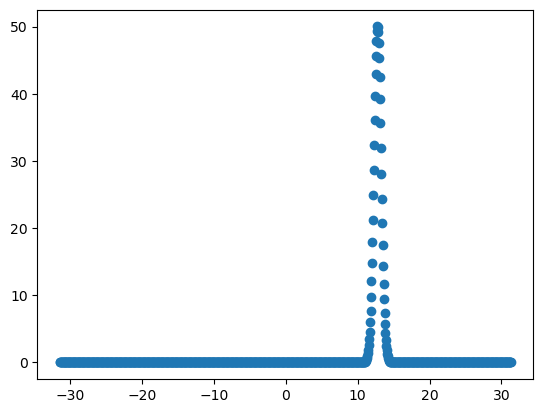

In [138]:
plt.scatter(np.fft.fftfreq(len(X)) * 2 * pi / dx, get_prob(np.fft.fft(ini_psi)))
plt.show()

In [7]:
ft_solver = FFTSolv(inter=50, cutoff=5)
print(ft_solver.dk)

0.012566370614359173


In [64]:
np.fft.fftfreq(10)

array([ 0. ,  0.1,  0.2,  0.3,  0.4, -0.5, -0.4, -0.3, -0.2, -0.1])

In [209]:
print(ft_solver.kmesh)

[-62.76902122 -62.70618937 -62.64335751 ...  62.64335751  62.70618937
  62.76902122]


In [211]:
print(ft_solver.kmesh)

[  0.           0.06276902   0.12553804   0.18830706   0.25107608
   0.31384511   0.37661413   0.43938315   0.50215217   0.56492119
   0.62769021   0.69045923   0.75322825   0.81599728   0.8787663
   0.94153532   1.00430434   1.06707336   1.12984238   1.1926114
   1.25538042   1.31814945   1.38091847   1.44368749   1.50645651
   1.56922553   1.63199455   1.69476357   1.75753259   1.82030162
   1.88307064   1.94583966   2.00860868   2.0713777    2.13414672
   2.19691574   2.25968476   2.32245379   2.38522281   2.44799183
   2.51076085   2.57352987   2.63629889   2.69906791   2.76183693
   2.82460595   2.88737498   2.950144     3.01291302   3.07568204
   3.13845106   3.20122008   3.2639891    3.32675812   3.38952715
   3.45229617   3.51506519   3.57783421   3.64060323   3.70337225
   3.76614127   3.82891029   3.89167932   3.95444834   4.01721736
   4.07998638   4.1427554    4.20552442   4.26829344   4.33106246
   4.39383149   4.45660051   4.51936953   4.58213855   4.64490757
   4.7076765